# Consolidate Output
This program reads in the data from runs on the BlueBEAR cluster via RDS and appends them on to the existing `malatium` and `copper` dataframes, saving them as `atium` and `bronze` respectively.

## What are we flagging?

We want to flag:
- Poor convergence in the splitting and inclination values
- Rhat values
- The effective n percentage
- The location on the HR diagram
 - MS: log(g) > 4.2 and Teff < 6250
 - SG: log(g) < 4.2
 - H: log(g) > 4.2 and Teff > 6250

In [1]:
import numpy as np
import lightkurve as lk
import pandas as pd
import fnmatch as fnm
import seaborn as sns
import astropy.units as u
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


Read in the existing dataframe

In [2]:
cols = ['KIC','Teff','age','dnu','eTeff','ednu','efeh','enumax','feh','loage','lomodlogg','lomodmass','lomodrad','modlogg','modmass','modrad','numax','source','upage','upmodlogg', 'upmodmass','upmodrad','G','bprp']
mal = pd.read_csv('../../data/malatium.csv', usecols=cols)
cop = pd.read_csv('../../data/copper.csv', index_col=0)

## Add the classification

In [3]:
mal['hrclass'] = ''
s = np.where((mal.modlogg > 4.2) & (mal.Teff < 6250))[0]
mal.loc[s, 'hrclass'] = 'MS'
s = np.where((mal.modlogg < 4.2))[0]
mal.loc[s, 'hrclass'] = 'SG'
s = np.where((mal.modlogg > 4.2) & (mal.Teff > 6250))[0]
mal.loc[s, 'hrclass'] = 'H'

## Add the mode results

Parse all the data, including some flags:

`empty   : run not yet done`

`rhat_1  : has at least one rhat > 1.1. Major concern, exclude from sample`

`nosum   : there is no summary available for some reason`


In [4]:
cop['f'] = np.nan
cop['f_e'] = np.nan
cop['g'] = np.nan
cop['g_e'] = np.nan
cop['A'] = np.nan
cop['A_e'] = np.nan
cop['H'] = np.nan
cop['H_e'] = np.nan
cop['flag'] = ''

In [5]:
incomplete = 0
for idx in tqdm(range(95)):
    kic = str(mal.loc[idx].KIC)
    files = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/peakbag/{}/*chains.csv'.format(str(kic)))

    try:
        chains = pd.read_csv(files[0],index_col=0)
        lis = list(chains)
    except IndexError:
        incomplete += 1
        cop.loc[cop.KIC == kic, 'flag'] = 'empty'
        continue

    # Lets do each mode in turn
    for mode in [0,1,2]:
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'f'] = np.median(chains[fnm.filter(lis, f'f{mode}_*')], axis=0)
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'f_e'] = np.std(chains[fnm.filter(lis, f'f{mode}_*')], axis=0).values
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'g'] = np.median(chains[fnm.filter(lis, f'g{mode}_*')], axis=0)
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'g_e'] = np.std(chains[fnm.filter(lis, f'g{mode}_*')], axis=0).values
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'A'] = np.median(chains[fnm.filter(lis, f'a{mode}_*')], axis=0)
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'A_e'] = np.std(chains[fnm.filter(lis, f'a{mode}_*')], axis=0).values
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'H'] = np.median(chains[fnm.filter(lis, f'h{mode}_*')], axis=0)
        cop.loc[(cop.KIC==kic)&(cop.l==mode),'H_e'] = np.std(chains[fnm.filter(lis, f'h{mode}_*')], axis=0).values    
    
    #Lets copy over the Rhats for each mode and flag if needed
    try:
        summary = pd.read_csv(files[0].replace('chains','summary'), index_col=0)
        rhats = summary.loc[fnm.filter(lis, '*__*')].Rhat.values
        
        if any(np.abs(rhats - 1.) >= 0.1):
            print('Rhats greater than 1.1 for KIC {}'.format(str(kic)))
            cop.loc[cop.KIC==kic, 'flag'] = 'rhat_1'

        
    except FileNotFoundError:
        print('No summary file for KIC {}'.format(str(kic)))
        mal.loc[idx, 'flag'] = 'nosum'
        pass
print(f'There are {incomplete} stars yet to run.')    

 74%|███████▎  | 70/95 [00:29<00:10,  2.41it/s]

Rhats greater than 1.1 for KIC 4143755


100%|██████████| 95/95 [00:35<00:00,  2.68it/s]

There are 27 stars yet to run.


In [6]:
cop.to_csv('../../data/bronze.csv')

### Add the parameters results

Read in the existing dataframes

In [7]:
#Add the necessary columns to malatium
mal['nus*'] = np.nan
mal['l_nus*'] = np.nan
mal['u_nus*'] = np.nan

mal['cosi'] = np.nan
mal['l_cosi'] = np.nan
mal['u_cosi'] = np.nan

mal['i'] = np.nan
mal['l_i'] = np.nan
mal['u_i'] = np.nan

mal['nus'] = np.nan
mal['l_nus'] = np.nan
mal['u_nus'] = np.nan

mal['P'] = np.nan
mal['l_P'] = np.nan
mal['u_P'] = np.nan

mal['vsini'] = np.nan
mal['l_vsini'] = np.nan
mal['u_vsini'] = np.nan

mal['fit_numax'] = np.nan
mal['efit_numax'] = np.nan
mal['fit_d01'] = np.nan
mal['efit_d01'] = np.nan
mal['fit_d02'] = np.nan
mal['efit_d02'] = np.nan
mal['fit_epsilon'] = np.nan
mal['efit_epsilon'] = np.nan

mal['V1'] = np.nan
mal['eV1'] = np.nan

mal['V2'] = np.nan
mal['eV2'] = np.nan

mal['rhat_flag'] = ''
mal['corner_flag'] = np.nan
mal['neff_xsplit'] = np.nan
mal['neff_cosi'] = np.nan
mal['neff_split'] = np.nan
mal['neff_i'] = np.nan

In [8]:
incomplete = 0
for idx in tqdm(range(95)):
    kic = mal.loc[idx].KIC
    files = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/peakbag/{}/*chains.csv'.format(str(kic)))

    # Check to see if run is done
    try:
        chains = pd.read_csv(files[0],index_col=0)
        niters = len(chains)
    except IndexError:
        incomplete += 1
        mal.loc[idx, 'rhat_flag'] = 'empty'
        continue

    #Flag Rhat values & Neff values
    try:
        summary = pd.read_csv(files[0].replace('chains','summary'), index_col=0)
        rhats = summary.loc[['xsplit','cosi','i','split']].Rhat.values
        
        if any(np.abs(rhats - 1.) >= 0.01):
            print('Rhats greater than 1.01 for KIC {}'.format(str(kic)))
            mal.loc[idx, 'rhat_flag'] = 'rhat_01'  
        
        if any(np.abs(rhats - 1.) >= 0.1):
            print('Rhats greater than 1.1 for KIC {}'.format(str(kic)))
            mal.loc[idx, 'rhat_flag'] = 'rhat_1'

        neff = summary.loc[['xsplit','cosi','i','split']].n_eff
        mal.loc[idx, 'neff_xsplit'] = int(neff['xsplit'])
        mal.loc[idx, 'neff_cosi'] = int(neff['cosi'])
        mal.loc[idx, 'neff_split'] = int(neff['split'])
        mal.loc[idx, 'neff_i'] = int(neff['i'])
            
    except FileNotFoundError:
        mal.loc[idx, 'flag'] = 'nosum'
        pass
    
    l, m, up = np.percentile(chains['xsplit'].values,[15.9, 50, 84.1])
    mal.loc[idx, 'l_nus*'], mal.loc[idx, 'nus*'], mal.loc[idx, 'u_nus*'] = m-l, m, up-m
    
    l, m, up = np.percentile(chains['cosi'].values, [15.9, 50, 84.1])
    mal.loc[idx, 'l_cosi'], mal.loc[idx, 'cosi'], mal.loc[idx, 'u_cosi'] = m-l, m, up-m
    
    l, m, up = np.percentile(chains['split'].values,[15.9, 50, 84.1])
    mal.loc[idx, 'l_nus'], mal.loc[idx, 'nus'], mal.loc[idx, 'u_nus'] = m-l, m, up-m
    
    l, m, up = np.percentile(chains['i'].values, [15.9, 50, 84.1])    
    mal.loc[idx, 'l_i'], mal.loc[idx, 'i'], mal.loc[idx, 'u_i'] =  m-l, m, up-m
    
    m, up = np.percentile(chains['numax'].values, [50, 84.1])    
    mal.loc[idx, 'fit_numax'], mal.loc[idx, 'efit_numax'] =  m, up-m

    m, up = np.percentile(chains['d01'].values, [50, 84.1])    
    mal.loc[idx, 'fit_d01'], mal.loc[idx, 'efit_d01'] =  m, up-m
    
    m, up = np.percentile(chains['d02'].values, [50, 84.1])    
    mal.loc[idx, 'fit_d02'], mal.loc[idx, 'efit_d02'] =  m, up-m
    
    m, up = np.percentile(chains['epsilon'].values, [50, 84.1])    
    mal.loc[idx, 'fit_epsilon'], mal.loc[idx, 'efit_epsilon'] =  m, up-m
    
    m, up = np.percentile(chains['V1'].values, [50, 84.1])    
    mal.loc[idx, 'V1'], mal.loc[idx, 'eV1'] =  m, up-m
    
    m, up = np.percentile(chains['V2'].values, [50, 84.1])    
    mal.loc[idx, 'V2'], mal.loc[idx, 'eV2'] =  m, up-m    
    
    nus = u.Quantity(chains['split'].values, u.microhertz)
    Pchain = 1./nus.to(1./u.day).value
    l, m, up = np.percentile(Pchain, [15.9, 50, 84.1])  
    mal.loc[idx, 'l_P'], mal.loc[idx, 'P'], mal.loc[idx, 'u_P'] = m-l, m, up-m
    
    Rkm = u.Quantity(mal.loc[idx, 'modrad'], u.solRad).to(u.km)
    vsinichain = np.sin(chains['i'].values) * 2 * np.pi * Rkm / (1./nus.to(u.Hertz).value)
    l, m, up = np.percentile(vsinichain, [15.9, 50, 84.1])  
    mal.loc[idx, 'l_vsini'], mal.loc[idx, 'vsini'], mal.loc[idx, 'u_vsini'] = m-l, m, up-m
    
print(f'There are {incomplete} stars still to run.') 
print(f"Of these, {len(np.where((mal.rhat_flag == 'empty') & (mal.hrclass == 'MS'))[0])} lie in the MS region.")

 40%|████      | 38/95 [00:12<00:17,  3.20it/s]

Rhats greater than 1.01 for KIC 8938364
Rhats greater than 1.1 for KIC 8938364


 44%|████▍     | 42/95 [00:14<00:21,  2.42it/s]

Rhats greater than 1.01 for KIC 9139163


100%|██████████| 95/95 [00:29<00:00,  3.17it/s]

There are 27 stars still to run.
Of these, 14 lie in the MS region.


In [10]:
mal.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'corner_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i'],
      dtype='object')

In [9]:
mal

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,lomodlogg,lomodmass,lomodrad,modlogg,modmass,modrad,numax,source,upage,upmodlogg,upmodmass,upmodrad,G,bprp,hrclass,nus*,l_nus*,u_nus*,cosi,l_cosi,u_cosi,i,l_i,u_i,nus,l_nus,u_nus,P,l_P,u_P,vsini,l_vsini,u_vsini,fit_numax,efit_numax,fit_d01,efit_d01,fit_d02,efit_d02,fit_epsilon,efit_epsilon,V1,eV1,V2,eV2,rhat_flag,corner_flag,neff_xsplit,neff_cosi,neff_split,neff_i
0,1435467,6326,3.0164,70.369,77,0.034,0.10,6.3,0.01,0.3513,0.0088,0.0513,0.021,4.0997,1.3189,1.6925,1406.7,L,0.4951,0.0088,0.0304,0.018,8.779618,0.653815,SG,1.577364,0.090898,0.097947,0.447346,0.165311,0.100281,1.107001,0.115730,0.177881,1.769417,0.183700,0.185514,6.541180,0.620728,0.757775,11.669772,0.672485,0.724637,1411.428640,6.481355,0.458467,0.007581,0.073752,0.006002,1.119160,0.004587,1.391771,0.053642,0.995788,0.059509,,NaN,960.0,2229.0,1514.0,2289.0
1,2837475,6614,1.6270,75.729,77,0.041,0.10,8.2,0.01,0.1757,0.0066,0.0209,0.018,4.1635,1.4291,1.6385,1557.6,L,0.1118,0.0066,0.0190,0.015,8.398082,0.575040,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,NaN,NaN,NaN,NaN
2,3427720,6045,2.2339,120.068,77,0.031,0.10,10.7,-0.06,0.2396,0.0055,0.0095,0.009,4.3868,1.1080,1.1167,2737.0,L,0.2396,0.0044,0.0209,0.009,9.038882,0.742274,MS,0.301916,0.062498,0.056955,0.553276,0.366961,0.285242,0.984505,0.408266,0.398882,0.366378,0.089665,0.219100,31.590512,11.821919,10.236450,1.473754,0.305072,0.278017,2731.058836,7.210508,0.469237,0.002220,0.085480,0.002353,1.357064,0.001598,1.330013,0.037800,0.839940,0.031153,,NaN,4491.0,6127.0,4305.0,6779.0
3,3456181,6384,2.0901,52.264,77,0.041,0.10,8.3,-0.15,0.1278,0.0077,0.0190,0.027,3.9490,1.4975,2.1483,970.0,L,0.1278,0.0088,0.0304,0.027,9.559311,0.652382,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,NaN,NaN,NaN,NaN
4,3632418,6193,2.6331,60.704,77,0.019,0.10,3.0,-0.12,0.1757,0.0077,0.0209,0.024,4.0238,1.4082,1.9114,1166.8,L,0.1757,0.0077,0.0209,0.021,8.128324,0.689151,SG,0.983424,0.026577,0.027301,0.304472,0.170729,0.120434,1.261412,0.129474,0.175239,1.032888,0.054564,0.071934,11.205550,0.729588,0.624963,8.216637,0.222056,0.228105,1170.057463,3.799228,0.436497,0.004893,0.070572,0.004498,1.119302,0.002894,1.350952,0.034804,0.921996,0.034584,,NaN,3532.0,2171.0,2572.0,2201.0
5,3656476,5668,8.3663,93.194,77,0.018,0.10,7.0,0.25,1.5651,0.0077,0.0399,0.018,4.2251,1.0377,1.2996,1925.0,L,1.7248,0.0099,0.0513,0.021,9.472733,0.882620,MS,0.211519,0.019593,0.019755,0.463449,0.312849,0.281166,1.088913,0.358074,0.330708,0.240922,0.034820,0.086414,48.040844,12.682362,8.116435,1.201602,0.111304,0.112223,1925.310183,6.608759,0.449473,0.005176,0.052145,0.003412,1.450763,0.002493,1.247780,0.048457,0.796938,0.040597,,NaN,4456.0,5201.0,5963.0,5669.0
6,3735871,6107,2.3457,123.049,77,0.047,0.10,16.6,-0.04,0.8464,0.0066,0.0399,0.015,4.3956,1.0890,1.0957,2862.6,L,1.0380,0.0066,0.0399,0.012,9.645882,0.725026,MS,0.685687,0.054211,0.053086,0.335210,0.227320,0.234006,1.228968,0.263723,0.233728,0.732051,0.075632,0.135259,15.810470,2.465683,1.821666,3.284125,0.259646,0.254256,2864.647992,8.171951,0.467925,0.002540,0.091071,0.002258,1.325929,0.001671,1.276083,0.039740,0.831193,0.034676,,NaN,3484.0,2006.0,1544.0,1925.0
7,4914923,5805,7.5678,88.531,77,0.019,0.10,6.3,0.08,1.7886,0.0077,0.0494,0.024,4.1965,1.0586,1.3566,1817.0,L,1.6609,0.0099,0.0589,0.024,9.323963,0.828219,SG,0.390524,0.025946,0.025961,0.686460,0.185238,0.095129,0.814187,0.140599,0.231599,0.541000,0.108941,0.107149,21.393839,3.536735,5.394345,2.315801,0.153858,0.153948,1813.119371,5.741888,0.446016,0.003765,0.060795,0.002932,1.379879,0.002161,1.303077,0.037338,0.790368,0.030525,,NaN,2800.0,1361.0,2058.0,1470.0
8,5184732,5846,4.8529,95.545,77,0.024,0.10,4.4,0.36,0.8784,0.0099,0.0589,0.021,4.2548,1.1479,1.3206,2089.3,L,1.5651,0.0077,0.0399,0.015,8.157801,0.828958,MS,0.549770,0.019324,0.019082

## Finally I'm going to calculate the BP-RP errors.
SQL is broken and I can't add this script to get_data.ipynb, so I'm doing it here.

In [11]:
from astropy.table import Table
gkf = Table.read('../../data/kepler_dr2_1arcsec.fits', format='fits').to_pandas()

/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
gkf = Table.read('../../data/kepler_dr2_1arcsec.fits', format='fits').to_pandas().rename(columns={
                    'kepid':'KIC'})[['KIC','phot_bp_mean_flux',
                                     'phot_bp_mean_flux_error',
                                     'phot_rp_mean_flux',
                                     'phot_rp_mean_flux_error']]

In [13]:
ebp = gkf['phot_bp_mean_flux_error'] / (gkf['phot_bp_mean_flux']) * np.log(10)
erp = gkf['phot_rp_mean_flux_error'] / (gkf['phot_rp_mean_flux']) * np.log(10)
gkf['ebprp'] = np.sqrt(ebp**2 + erp**2)
mal = pd.merge(mal, gkf[['KIC','ebprp']], on='KIC', how='left')

In [15]:
mal.to_csv('../../data/atium.csv')

## Having a look at the data

In [17]:
len(mal.loc[mal.hrclass == 'MS'])

41

In [16]:
mal.loc[mal.hrclass == 'MS']

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,lomodlogg,lomodmass,lomodrad,modlogg,modmass,modrad,numax,source,upage,upmodlogg,upmodmass,upmodrad,G,bprp,hrclass,nus*,l_nus*,u_nus*,cosi,l_cosi,u_cosi,i,l_i,u_i,nus,l_nus,u_nus,P,l_P,u_P,vsini,l_vsini,u_vsini,fit_numax,efit_numax,fit_d01,efit_d01,fit_d02,efit_d02,fit_epsilon,efit_epsilon,V1,eV1,V2,eV2,rhat_flag,corner_flag,neff_xsplit,neff_cosi,neff_split,neff_i,ebprp
2,3427720,6045,2.2339,120.068,77,0.031,0.10,10.7,-0.06,0.2396,0.0055,0.0095,0.0090,4.3868,1.1080,1.1167,2737.0,L,0.2396,0.0044,0.0209,0.0090,9.038882,0.742274,MS,0.301916,0.062498,0.056955,0.553276,0.366961,0.285242,0.984505,0.408266,0.398882,0.366378,0.089665,0.219100,31.590512,11.821919,10.236450,1.473754,0.305072,0.278017,2731.058836,7.210508,0.469237,0.002220,0.085480,0.002353,1.357064,0.001598,1.330013,0.037800,0.839940,0.031153,,NaN,4491.0,6127.0,4305.0,6779.0,0.003221
5,3656476,5668,8.3663,93.194,77,0.018,0.10,7.0,0.25,1.5651,0.0077,0.0399,0.0180,4.2251,1.0377,1.2996,1925.0,L,1.7248,0.0099,0.0513,0.0210,9.472733,0.882620,MS,0.211519,0.019593,0.019755,0.463449,0.312849,0.281166,1.088913,0.358074,0.330708,0.240922,0.034820,0.086414,48.040844,12.682362,8.116435,1.201602,0.111304,0.112223,1925.310183,6.608759,0.449473,0.005176,0.052145,0.003412,1.450763,0.002493,1.247780,0.048457,0.796938,0.040597,,NaN,4456.0,5201.0,5963.0,5669.0,0.003556
6,3735871,6107,2.3457,123.049,77,0.047,0.10,16.6,-0.04,0.8464,0.0066,0.0399,0.0150,4.3956,1.0890,1.0957,2862.6,L,1.0380,0.0066,0.0399,0.0120,9.645882,0.725026,MS,0.685687,0.054211,0.053086,0.335210,0.227320,0.234006,1.228968,0.263723,0.233728,0.732051,0.075632,0.135259,15.810470,2.465683,1.821666,3.284125,0.259646,0.254256,2864.647992,8.171951,0.467925,0.002540,0.091071,0.002258,1.325929,0.001671,1.276083,0.039740,0.831193,0.034676,,NaN,3484.0,2006.0,1544.0,1925.0,0.003556
8,5184732,5846,4.8529,95.545,77,0.024,0.10,4.4,0.36,0.8784,0.0099,0.0589,0.0210,4.2548,1.1479,1.3206,2089.3,L,1.5651,0.0077,0.0399,0.0150,8.157801,0.828958,MS,0.549770,0.019324,0.019082,0.320020,0.190615,0.171360,1.245046,0.187923,0.195982,0.581391,0.035179,0.060122,19.907543,1.865728,1.282151,3.173614,0.111548,0.110155,2094.483660,5.369753,0.470101,0.004099,0.062184,0.002980,1.377708,0.002182,1.286547,0.035929,0.817543,0.027157,,NaN,3936.0,2620.0,3132.0,2730.0,0.004263
10,5950854,5853,8.9253,96.629,77,0.102,0.10,21.9,-0.23,1.1498,0.0066,0.0304,0.0120,4.2383,0.9693,1.2366,1926.7,L,1.1179,0.0066,0.0285,0.0180,10.908018,0.798314,MS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,NaN,NaN,NaN,NaN,0.002631
11,6106415,6037,5.0286,104.074,77,0.023,0.10,4.6,-0.04,1.1179,0.0088,0.0399,0.0180,4.2955,1.0681,1.2186,2248.6,L,1.2776,0.0088,0.0513,0.0180,7.059701,0.730820,MS,0.693732,0.015790,0.015694,0.290564,0.142277,0.103659,1.275980,0.110406,0.145981,0.725476,0.030301,0.037180,15.953761,0.777763,0.695386,3.695342,0.084110,0.083599,2252.717609,5.132014,0.466722,0.004731,0.064654,0.002880,1.345529,0.001671,1.277933,0.028698,0.797435,0.024374,,NaN,8627.0,2427.0,3895.0,2472.0,0.003195
12,6116048,6033,9.5801,100.754,77,0.017,0.10,5.5,-0.23,1.9004,0.0088,0.0513,0.0180,4.2537,0.9389,1.1916,2126.9,L,2.1559,0.0121,0.0494,0.0210,8.369842,0.734601,MS,0.625017,0.018678,0.018865,0.237479,0.154440,0.167934,1.331026,0.177660,0.156635,0.646558,0.029297,0.045843,17.901072,1.185210,0.849631,3.255547,0.097288,0.098265,2128.889250,5.834058,0.463643,0.005671,0.063496,0.002862,1.342615,0.002191,1.280900,0.035061,0.812096,0.027738,,NaN,5063.0,3134.0,4187.0,3241.0,0.004195
15,6603624,5674,7.8234,110.128,77,0.012,0.10,5.4,0.28,0.8624,0.0044,0.0209,0.0090,4.3197,1.0092,1.1497,2384.0,L,0.9422,0.0055,0.0285,0.0120,9.043605,0.894081,MS,1.134471,0.132165,0.127663,0.992771,0.001680,0.001561,0.120318,0.013795,0.013267,9.500444,0.277923,0.151209,1.218267,0.019086,0.036713,5.701380,0.664208,0.641580,2388.973503,7.000159,0.471306,0.003861,0.049349,0.002911,1.498414,0.00

## By-Eye investigations

I'm going to add flags based on by-eye inspection of the corner plots as well.

`-1 : no data`

`0   : no issues`

`1 : poorly constrained rotational parameters`

`2  : bimodal distributions`

`3   : divergence/poor sampling`

Are we going to investigate the corners? (y/n) y
Star 1435467 has not completed yet | idx 0
Star 2837475 has not completed yet | idx 1
Star 3427720 has not completed yet | idx 2
Star 3456181 has not completed yet | idx 3
Star 3632418 has not completed yet | idx 4
Star 3656476 has not completed yet | idx 5
Star 3735871 has not completed yet | idx 6
Star 4914923 has not completed yet | idx 7
Star 5184732 has not completed yet | idx 8


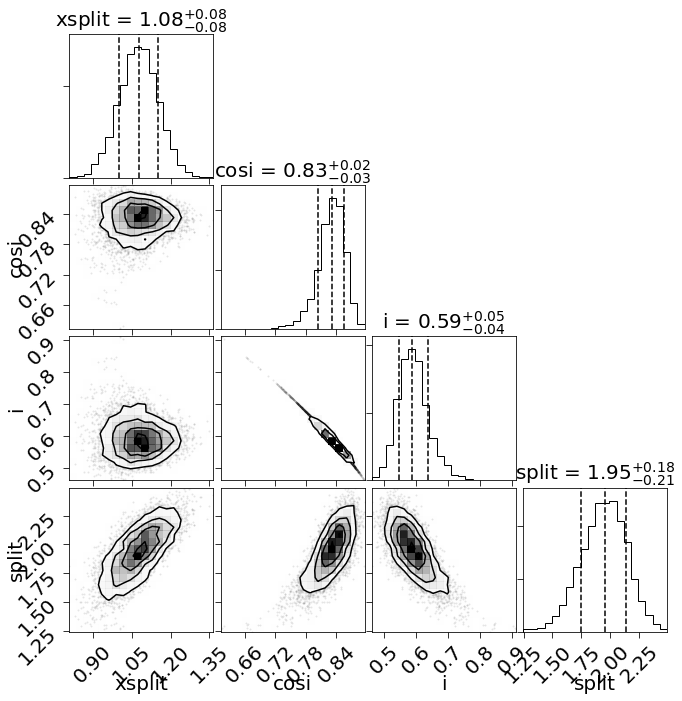

KIC 5773345
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 5950854 has not completed yet | idx 10
Star 6106415 has not completed yet | idx 11
Star 6116048 has not completed yet | idx 12
Star 6225718 has not completed yet | idx 13
Star 6508366 has not completed yet | idx 14
Star 6603624 has not completed yet | idx 15
Star 6679371 has not completed yet | idx 16


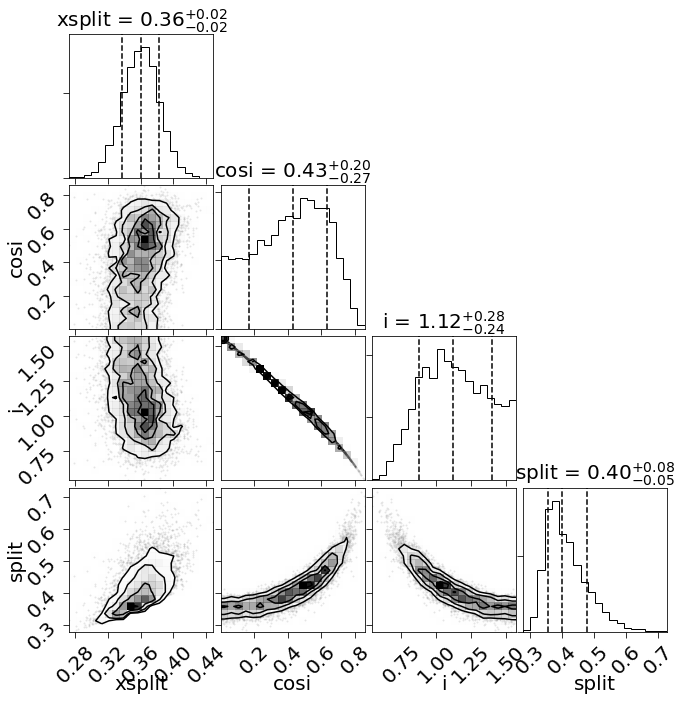

KIC 6933899
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 7103006 has not completed yet | idx 18
Star 7106245 has not completed yet | idx 19
Star 7206837 has not completed yet | idx 20
Star 7296438 has not completed yet | idx 21
Star 7510397 has not completed yet | idx 22
Star 7680114 has not completed yet | idx 23


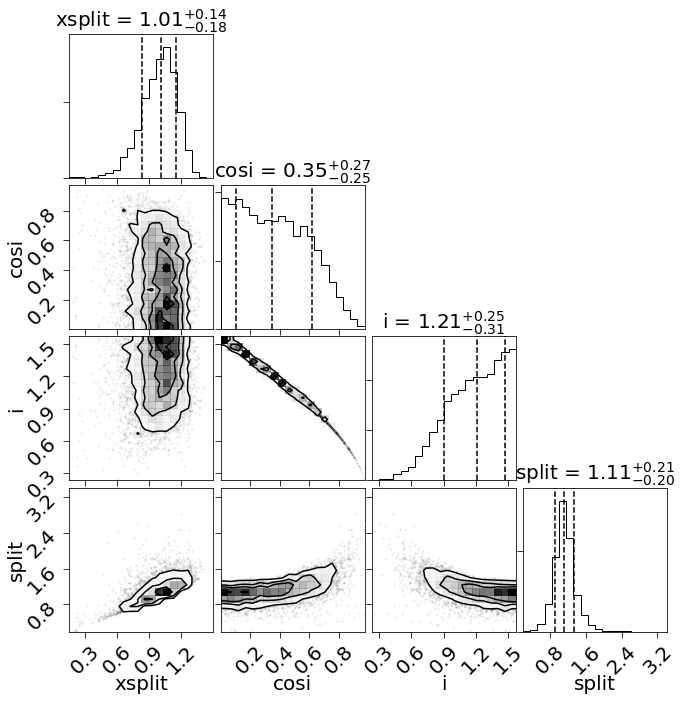

KIC 7771282
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 7871531 has not completed yet | idx 25
Star 7940546 has not completed yet | idx 26
Star 7970740 has not completed yet | idx 27
Star 8006161 has not completed yet | idx 28
Star 8150065 has not completed yet | idx 29
Star 8179536 has not completed yet | idx 30
Star 8228742 has not completed yet | idx 31
Star 8379927 has not completed yet | idx 32
Star 8394589 has not completed yet | idx 33


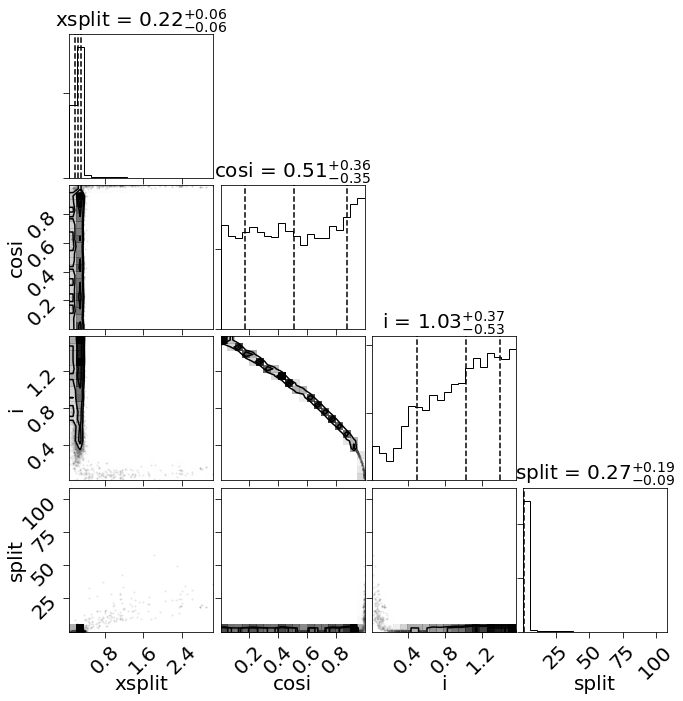

KIC 8424992
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 8694723 has not completed yet | idx 35
Star 8760414 has not completed yet | idx 36
Star 8938364 has not completed yet | idx 37
Star 9025370 has not completed yet | idx 38
Star 9098294 has not completed yet | idx 39
Star 9139151 has not completed yet | idx 40
Star 9139163 has not completed yet | idx 41
Star 9206432 has not completed yet | idx 42


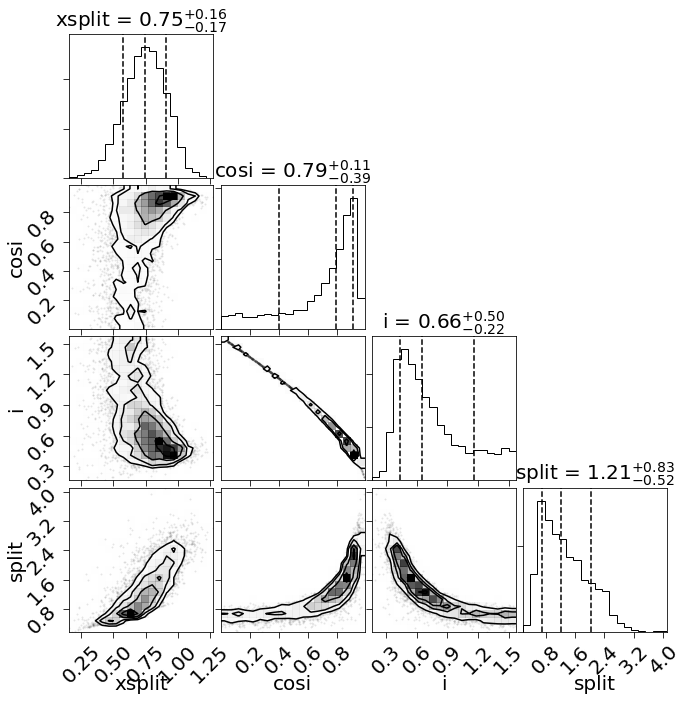

KIC 9353712
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0


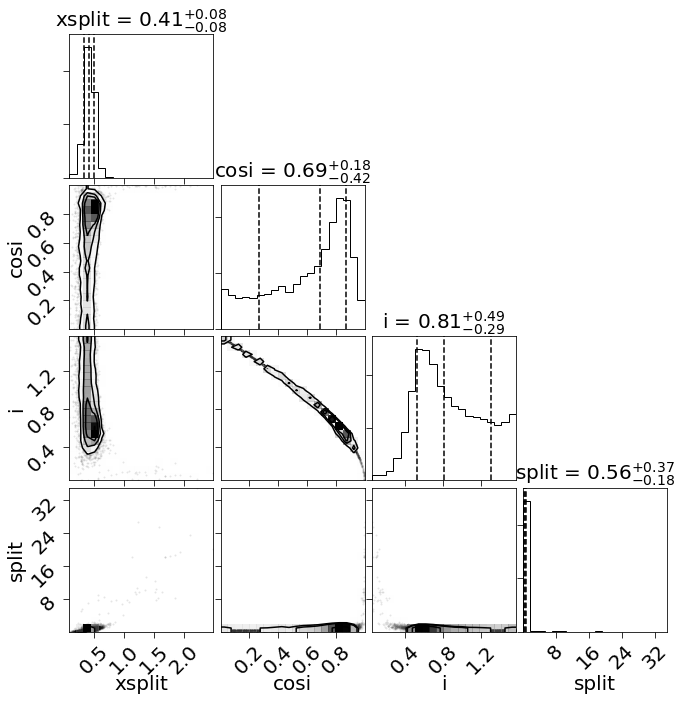

KIC 9410862
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 9414417 has not completed yet | idx 45
Star 9812850 has not completed yet | idx 46
Star 9955598 has not completed yet | idx 47
Star 9965715 has not completed yet | idx 48
Star 10068307 has not completed yet | idx 49


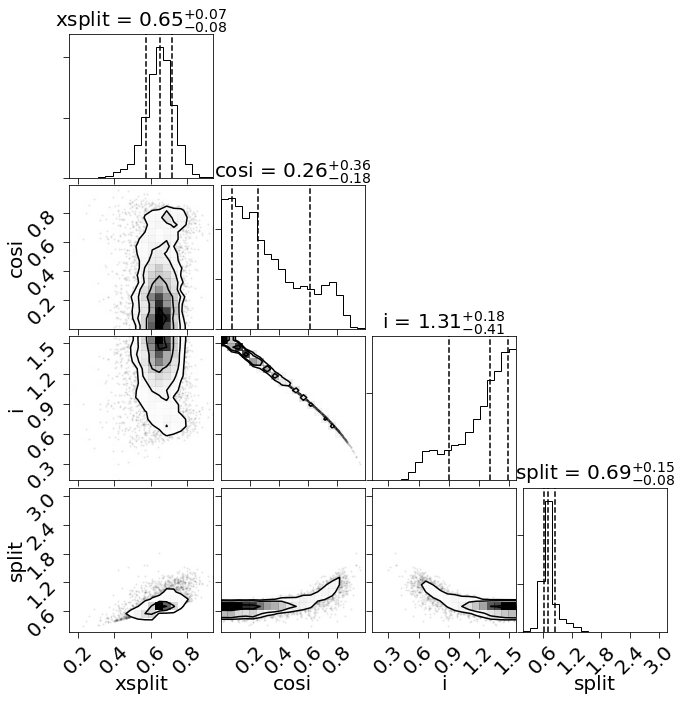

KIC 10079226
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 10162436 has not completed yet | idx 51
Star 10454113 has not completed yet | idx 52
Star 10516096 has not completed yet | idx 53
Star 10644253 has not completed yet | idx 54
Star 10730618 has not completed yet | idx 55
Star 10963065 has not completed yet | idx 56
Star 11081729 has not completed yet | idx 57
Star 11253226 has not completed yet | idx 58
Star 11772920 has not completed yet | idx 59
Star 12009504 has not completed yet | idx 60
Star 12069127 has not completed yet | idx 61
Star 12069424 has not completed yet | idx 62
Star 12069449 has not completed yet | idx 63
Star 12258514 has not completed yet | idx 64
Star 12317678 has not completed yet | idx 65


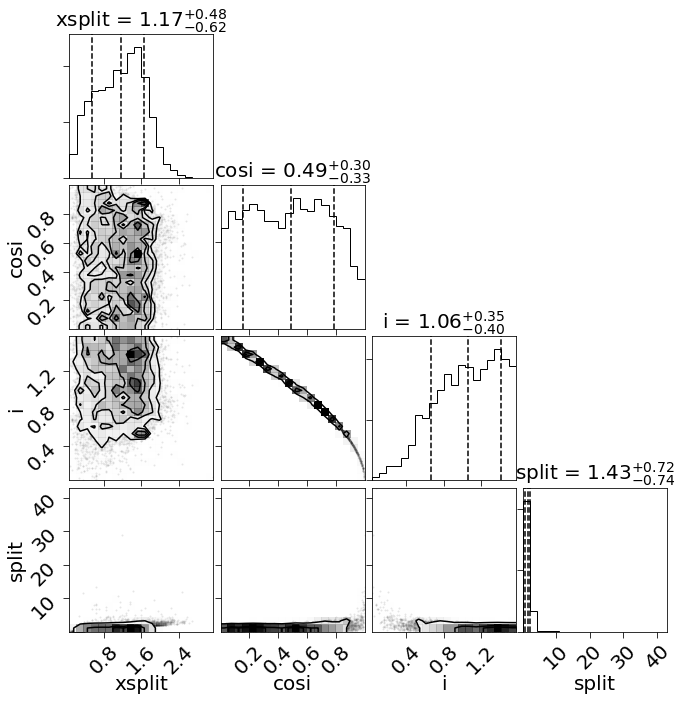

KIC 3425851
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 3544595 has not completed yet | idx 67


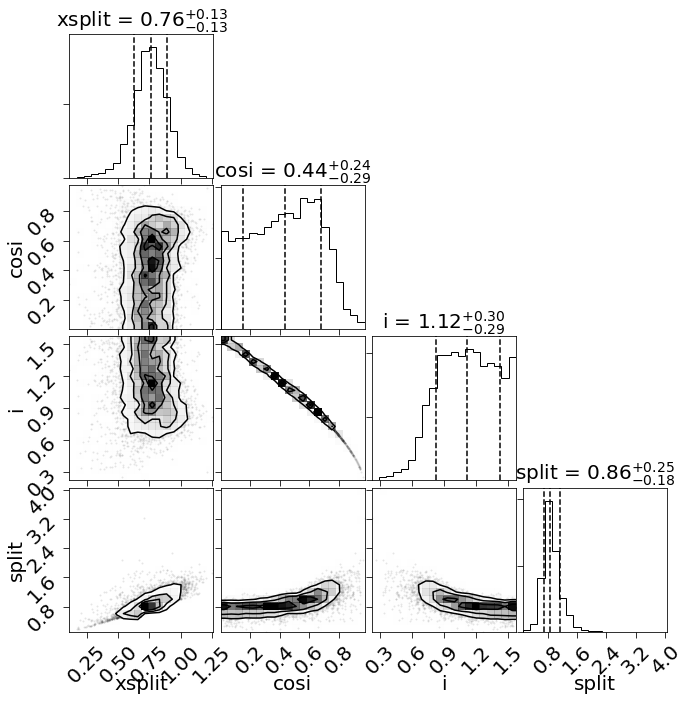

KIC 4141376
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0


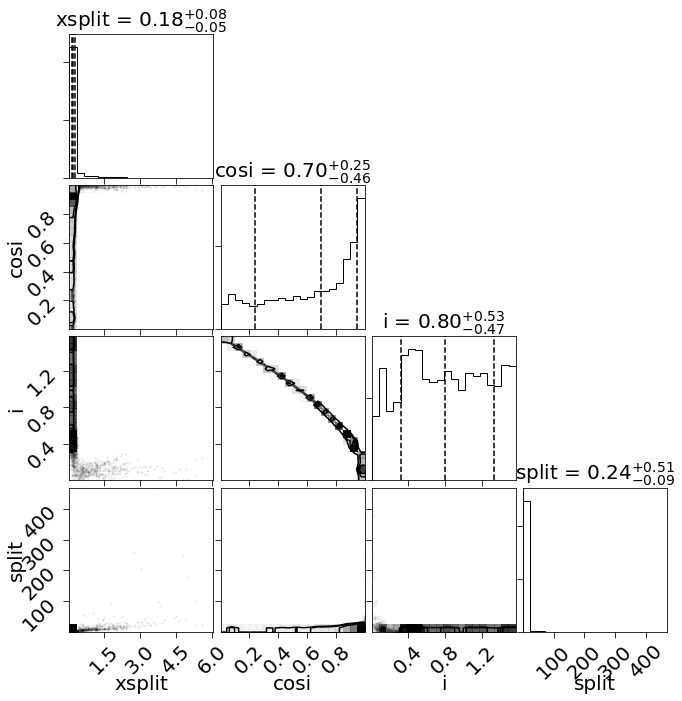

KIC 4143755
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 4349452 has not completed yet | idx 70
Star 4914423 has not completed yet | idx 71
Star 5094751 has not completed yet | idx 72
Star 5866724 has not completed yet | idx 73
Star 6196457 has not completed yet | idx 74
Star 6278762 has not completed yet | idx 75
Star 6521045 has not completed yet | idx 76
Star 7670943 has not completed yet | idx 77
Star 8077137 has not completed yet | idx 78
Star 8292840 has not completed yet | idx 79
Star 8349582 has not completed yet | idx 80
Star 8478994 has not completed yet | idx 81
Star 8494142 has not completed yet | idx 82
Star 8554498 has not completed yet | idx 83
Star 8866102 has not completed yet | idx 84
Star 9592705 has not completed yet | idx 85


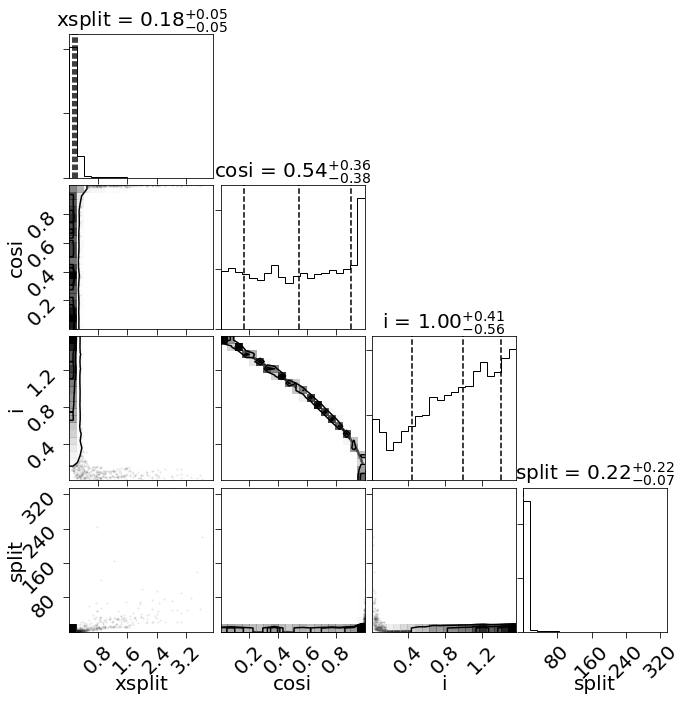

KIC 10514430
              0   : no issues 
              1 : poorly constrained rotational parameters
              2  : bimodal distributions
              3   : not converged
Flag: 0
Star 10586004 has not completed yet | idx 87
Star 10666592 has not completed yet | idx 88
Star 11133306 has not completed yet | idx 89
Star 11295426 has not completed yet | idx 90
Star 11401755 has not completed yet | idx 91
Star 11807274 has not completed yet | idx 92
Star 11853905 has not completed yet | idx 93
Star 11904151 has not completed yet | idx 94


In [9]:
import corner
choice = input('Are we going to investigate the corners? (y/n) ')

if choice == 'y':
    for idx in range(95):
        kic = mal.loc[idx].KIC
        files = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/peakbag/{}/*chains.csv'.format(str(kic)))

        try:
            
            chains = pd.read_csv(files[0],index_col=0)
        except IndexError:
            print('Star {} has not completed yet | idx {}'.format(str(kic), idx))
            mal.loc[idx, 'flagch'] = -1
            continue
            
        labels=['xsplit','cosi','i','split']
        chain = np.array([chains[label] for label in labels])
        
        corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84]
                      ,show_titles=True)
        plt.show()
        
        print('KIC {}\n\
              0   : no issues \n\
              1 : poorly constrained rotational parameters\n\
              2  : bimodal distributions\n\
              3   : not converged'.format(str(kic)))
        flag = int(input('Flag: '))
        mal.loc[idx, 'chainflag'] = flag
        
else:
    mal['chainflag'] = pd.read_csv('../../data/atium.csv',usecols=['chainflag'])

### Finally I'm going to calculate the BP-RP errors.
SQL is broken and I can't add this script to get_data.ipynb, so I'm doing it here.

In [10]:
from astropy.table import Table
gkf = Table.read('../../data/kepler_dr2_1arcsec.fits', format='fits').to_pandas()

/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/oliver/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
gkf = Table.read('../../data/kepler_dr2_1arcsec.fits', format='fits').to_pandas().rename(columns={
                    'kepid':'KIC'})[['KIC','phot_bp_mean_flux',
                                     'phot_bp_mean_flux_error',
                                     'phot_rp_mean_flux',
                                     'phot_rp_mean_flux_error']]

In [12]:
ebp = gkf['phot_bp_mean_flux_error'] / (gkf['phot_bp_mean_flux']) * np.log(10)
erp = gkf['phot_rp_mean_flux_error'] / (gkf['phot_rp_mean_flux']) * np.log(10)
gkf['ebprp'] = np.sqrt(ebp**2 + erp**2)
mal = pd.merge(mal, gkf[['KIC','ebprp']], on='KIC', how='left')

In [13]:
mal.to_csv('../../data/atium.csv')

In [14]:
mal

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,fit_epsilon,efit_epsilon,V1,eV1,V2,eV2,flag,chainflag,flagch,ebprp
0,1435467,6326,3.0164,70.369,77,0.034,0.10,6.3,0.01,0.3513,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.004119
1,2837475,6614,1.6270,75.729,77,0.041,0.10,8.2,0.01,0.1757,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.003113
2,3427720,6045,2.2339,120.068,77,0.031,0.10,10.7,-0.06,0.2396,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.003221
3,3456181,6384,2.0901,52.264,77,0.041,0.10,8.3,-0.15,0.1278,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.004179
4,3632418,6193,2.6331,60.704,77,0.019,0.10,3.0,-0.12,0.1757,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.002920
5,3656476,5668,8.3663,93.194,77,0.018,0.10,7.0,0.25,1.5651,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.003556
6,3735871,6107,2.3457,123.049,77,0.047,0.10,16.6,-0.04,0.8464,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.003556
7,4914923,5805,7.5678,88.531,77,0.019,0.10,6.3,0.08,1.7886,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.004597
8,5184732,5846,4.8529,95.545,77,0.024,0.10,4.4,0.36,0.8784,...,NaN,NaN,NaN,NaN,NaN,NaN,empty,NaN,-1.0,0.004263
9,5773345,6130,2.5533,57.303,84,0.030,0.09,5.7,0.21,0.2396,...,1.094296,0.004200,1.290506,0.048965,0.869429,0.062993,,0.0,NaN,0.003570
